<a id="title_ID"></a>
# Intermediate: Create TESS FFI Cutout using Python Requests

This notebook shows the user how to use the MAST programmatic interface to create a cutout of a small section of the TESS FFIs. For this example we will determine the RA and Dec for TIC ID = 261136679, Pi Mensae. We then perform a query to determine which sectors contain this RA and Dec, peform a cutout of the FFI timeseries, open the resulting target pixel files, and plot the first image. 

This tutorial shows the users how to do the following: use astroquery.catalogs to query the TIC, use the python requests module to query the available sectors, and use python requests to obtain an FFI cutout with astrocut.

The online version of Tesscut, as well as links to the documentation can be found here, https://mast.stsci.edu/tesscut/.


### Table of Contents 
  [Astroquery Search of the TIC](#catalog_ID) <br> 
  [Request a FFI Cutout](#tesscut_ID) <br>
  [Additional Resources](#resources_ID) <br> 
  [About this Notebook](#about_ID) 

***

## Import Statements
<a id="imports_ID"></a>

We start with a few import statements.
- *numpy* to handle array functions
- *astropy.io.fits* for accessing FITS files
- *astropy.wcs.WCS* to interpret the World Coordinate Systems
- *matplotlib.pyplot* for plotting the data
- *astroquery.mast* to do the catalog search. 
- *zipfile* to unzip the downloaded file

For ease of use later on, we also set a the root url for our requests. 

In [1]:
import numpy as np
from astropy.io import fits
import requests
from astroquery.mast import Catalogs
import zipfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt

%matplotlib inline

urlroot = "https://mast.stsci.edu/tesscut/api/v0.1"

<a id="catalog_ID"></a>
## Get RA and Dec of your Target Using Astroquery Catalogs

Here we do a cone search using `Catalogs.query_object` on the TIC catalog around our desired TIC ID. The advantage of doing this is that it gives us the nearby stars as well as the star we are looking for. The resulting table is sorted by distance from the requested object. We print out the ID and a few other TIC quantities to ensure we found the star we were looking for. 

In [2]:
ticid = 261136679

starName = "TIC " + str(ticid)
radSearch = 5 / 60 # radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
Ra = catalogData[0]['ra']
Dec = catalogData[0]['dec']

# Print out the first five rows in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

    ID     Tmag   Jmag      ra       dec     objType
--------- ------ ------ --------- ---------- -------
261136679  5.097  4.869 84.291198 -80.469143    STAR
261139071 13.995 13.495 84.257651  -80.46656    STAR
261136683 17.005 15.853 84.339545 -80.481056    STAR
261136676 17.059  16.48 84.334532 -80.454208    STAR
261139074 16.588 15.801 84.413579 -80.473656    STAR


In [3]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 14

# Make it a list of Ra, Dec pairs of the bright ones. So this is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

10

***

## Perform a Sector Query 
<a id="catalog_ID"></a>
Using the TESS sector information service, we make a request to determine which sectors/cameras/CCDs contain data for this target. Remember that there is a set of FFIs for each TESS sector and those are broken up into 4 cameras which each have 4 CCDs.  We will do this with a radius=0 cone search to find only those FFI sets that contain the star of interest. You can also make the query using a larger radius, which may be important if the star is near the edge of one of the CCDs.
<p>
Note, the request is returned in a json format. The 'results' key contains an array of dictionaries with the information we are looking for.  

In [4]:
url = urlroot + "/sector"

myparams = {"ra":Ra, "dec":Dec, "radius":"0m"}

requestData = requests.get(url = url, params = myparams)

print(requestData.headers.get('content-type'))

application/json; charset=UTF-8


The resulting dictionary of information is stored in results. This target is only in sector 1.

In [5]:
sectors = requestData.json()['results']
print(sectors)

[{'sectorName': 'tess-s0001-4-2', 'sector': '0001', 'camera': '4', 'ccd': '2'}, {'sectorName': 'tess-s0004-4-3', 'sector': '0004', 'camera': '4', 'ccd': '3'}, {'sectorName': 'tess-s0008-4-4', 'sector': '0008', 'camera': '4', 'ccd': '4'}]


***

<a id="tesscut_ID"></a>
## Request a FFI Cutout with Astrocut
Astrocut is the tool that runs the cutout service around the RA and Dec that were requested. It delivers a zipped file containing a cutout for each set of FFIs as listed above. It is also possible to request only one sector using the "sector" parameter.  For tesscut x refers to the CCD columns and y refers to the CCD rows. Distance can be input in a variety of units, I picked pixels ("px").

< Response [200] > means that your request succeeded.

In [6]:
myparams = {"ra":Ra, "dec":Dec, "x":35, "y":45, 
           "units":"px", "sector":"All"}

url = urlroot + "/astrocut"

r = requests.get(url = url, params = myparams)

print(r)
print(r.headers.get('content-type'))

<Response [200]>
application/zip


Create a zip file with the name astrocut.zip containing the content returned from the request.

In [7]:
open('astrocut.zip', 'wb').write(r.content)

104662864

### Open the zip file so we can get at the file.
We use python's zipfile to unzip the file, but this could also be done using unzip from the command line. In many cases you will get more than one file, one for each sector that observed the star.  If you ask for a large cutout, you might also get more than one because the pixels are on more than one CCD.  In this case, we got back one file. The name contains the RA and Dec as well as the sector number, camera and chip. 

In [8]:
zipRef = zipfile.ZipFile('astrocut.zip','r')
zipRef.extractall('.')
zipRef.close()

# Get list of cuotut names
cutoutnames = zipRef.namelist()
print(cutoutnames)

['tess-s0001-4-2_84.291198_-80.469143_35x45_astrocut.fits', 'tess-s0004-4-3_84.291198_-80.469143_35x45_astrocut.fits', 'tess-s0008-4-4_84.291198_-80.469143_35x45_astrocut.fits']


### Inspect the contents of the file.
Use the fits.info function to see the contents of the file. It has three extensions just like a normal target pixel file. Most of the interesting information is in the PIXELS extension.

In [9]:
file1 = cutoutnames[0]
fits.info(file1)

Filename: tess-s0001-4-2_84.291198_-80.469143_35x45_astrocut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    278   1282R x 12C   [D, E, J, 1575J, 1575E, 1575E, 1575E, 1575E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU       146   (35, 45)   float64   


In [10]:
hdu1 = fits.open(file1)
hdu1[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '1575J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(35, 45)'
    name = 'FLUX'; format = '1575E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 45)'
    name = 'FLUX_ERR'; format = '1575E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 45)'
    name = 'FLUX_BKG'; format = '1575E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 45)'
    name = 'FLUX_BKG_ERR'; format = '1575E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 45)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'FFI_FILE'; format = '38A'; unit = 'pixel'
)

[Top of Page](#title_ID)

<a id="plot_image"></a>
## Plot the First Image of the Time Series


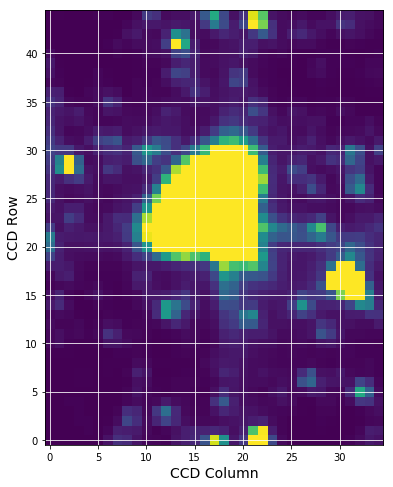

In [11]:
firstImage = hdu1[1].data['FLUX'][0]
fig = plt.figure(figsize=(8,8))
plt.imshow(firstImage, origin = 'lower', cmap = plt.cm.viridis, \
           vmax = np.percentile(firstImage,92), vmin = np.percentile(firstImage,5))
plt.xlabel('CCD Column', fontsize = 14)
plt.ylabel('CCD Row', fontsize = 14)
plt.grid(axis = 'both', color = 'white', ls = 'solid')

### Add a WCS to the image and mark the requested star as well as nearby stars.
We use the WCS in the header to place a red dot on the image for the catalog position of the star on the figure as a demonstration of the WCS. The orange dots are the nearby stars found in the cone search done above. 

**Note. The WCS is based on the WCS stored in the FFI file for the central part of the time series and there can be some motion during the sector that is not captured.**

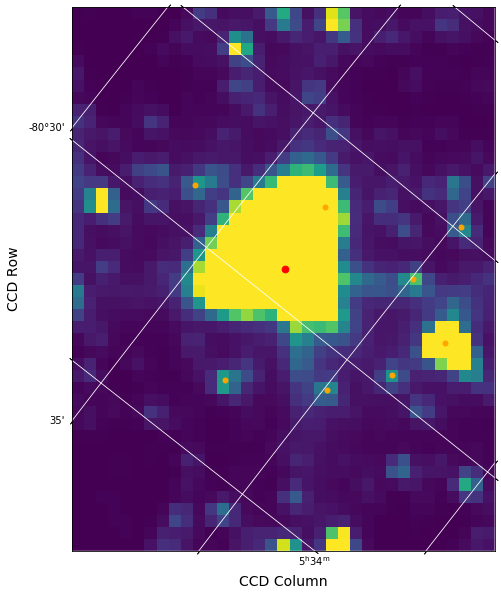

In [12]:
wcs = WCS(hdu1[2].header)

fig = plt.figure(figsize = (10,10))
fig.add_subplot(111, projection = wcs)
plt.imshow(firstImage, origin = 'lower', cmap = plt.cm.viridis, vmax = np.percentile(firstImage,92),\
           vmin = np.percentile(firstImage,5))

plt.xlabel('CCD Column', fontsize = 14)
plt.ylabel('CCD Row', fontsize = 14)
plt.grid(axis = 'both', color = 'white', ls = 'solid')

starLoc = wcs.all_world2pix([[Ra,Dec]],0)  #Second is origin
plt.scatter(starLoc[0,0], starLoc[0,1], s = 45, color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:], 0)
plt.scatter(nearbyLoc[1:,0], nearbyLoc[1:,1], s = 25, color = 'orange')

<a id="resources_ID"></a>
## Additional Resources
[TESScut API Documentation](https://mast.stsci.edu/tesscut/)<br>
[Astrocut Documentation](https://astrocut.readthedocs.io/en/latest/)<br>
[TESS Homepage](https://archive.stsci.edu/tess)<br>
[Astroquery](https://astroquery.readthedocs.io/en/latest/#installation)<br>


<a id="about_ID"></a>
## About this Notebook
**Author:** Susan E. Mullally, STScI Archive Scientist
<br>**Updated On:** 2018-11-29

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 